# Initialization

In [ ]:
# Imports
import torch

# Device
device = "cuda:0" if torch.cuda.is_available() else "cpu" # If using GPU then use mixed precision training.
print(f"Using device: {device}")

Using device: cuda:0


In [ ]:
# Load model
from torchvision import models

# Some parameters
img_size = 224 # ^2 pixels
num_classes = 200 # 200 birds in Dataset.

model = models.vgg16(num_classes=num_classes)  # Initialize the VGG16 model
model = torch.nn.DataParallel(model) # This is needed due to the training method used.

# Load the checkpoint
pretrained_model_path = "../vgg16_checkpoint_proper/model_best.pth.tar"
checkpoint = torch.load(pretrained_model_path)

# Remove 'module.' prefix
state_dict = checkpoint['state_dict']

# Load the modified state dict
model.load_state_dict(state_dict)

# Let it be the module in order for it to match the pytorch_grad_cam package
model = model.module.to(device)

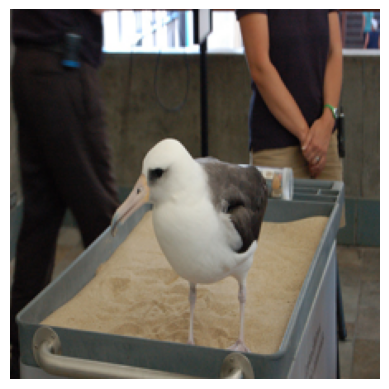

In [ ]:
# Load image
from utils import load_image_and_transform
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import numpy as np

IMAGE_PATH = "paper_imgs/example/Laysan_Albatross_0083_756.jpg"
image, image_tensor = load_image_and_transform(IMAGE_PATH)
image_tensor = image_tensor.unsqueeze(0).to(device)

plt.imshow(image)
#plt.imshow(np.transpose(np.array(image_tensor), (1,2,0)))
plt.axis('off')
plt.show()

In [ ]:
# CAM

In [ ]:
import torchvision

def explain_image(model, image, target=None, mode='GradCAM', use_contrastive_softmax=True):
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output
        return hook
    
    # Assert vgg model
    assert 'vgg' in str(type(model)), "Invalid model"
    
    # Register handle
    handle = model.features[28].register_forward_hook(get_activation('feature'))
    
    # Do a forward pass on the image
    if use_contrastive_softmax is True:
        # Adds a softmax layer, this is equivalent to using contrastive explanations.
        output = torch.softmax(model(image), dim=1)
    else:
        output = model(image)
        
    # Unregister handle
    handle.remove()
    
    # If no target registered, select the prediction
    if target is None:
        target = torch.argmax(output)
       
    # Get the gradient
    grad = torch.autograd.grad(
        inputs = activation['feature'],
        outputs = output[0, target],
        create_graph = True # What does this do?
    )[0][0]
    
    if mode == 'GradCAM':
        explanation = (activation['feature'].squeeze()*grad.mean(dim = [1,2], keepdim=True)).sum(dim = 0).unsqueeze(0)
        print(explanation.shape)
    elif mode == 'LA':
        raise NotImplemented
    else:
        raise ValueError("Unrecognized mode")
        
    size = 14
    return torch.nn.functional.interpolate(explanation.view(1,1,size,size), (224, 224), mode = 'bilinear', align_corners = True).squeeze()
    #return torchvision.transforms.Resize((224,224))(explanation)

cam = explain_image(model, image_tensor).squeeze().detach().cpu().numpy()

IndexError: index 40 is out of range

(224, 224)
(224, 224, 3)


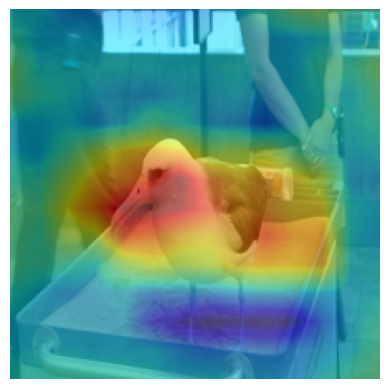

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

print(cam.shape)
print(image.shape)

# Normalize the heatmap
cam_normalized = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))

# Convert normalized heatmap to colormap
cam_colormap = cm.jet(cam_normalized)

# Convert colormap to an RGB image
cam_rgb = (cam_colormap[..., :3] * 255).astype(np.uint8)

# Resize the heatmap to match the size of the image
cam_resized = cv2.resize(cam_rgb, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_LINEAR)

# Ensure the original image is in uint8 format
if image.dtype != np.uint8:
    image_uint8 = (image * 255).astype(np.uint8)
else:
    image_uint8 = image

# Overlay the heatmap on the original image
combined_image = cv2.addWeighted(image_uint8, 0.5, cam_resized, 0.5, 0)

# Display the combined image
plt.imshow(combined_image)
plt.axis('off')  # Turn off axis numbers
plt.show()


In [ ]:
A = torch.softmax(model(image_tensor), dim=1).detach().cpu().numpy()


array([[3.5368121e-06, 8.2611793e-01, 1.5084534e-05, 2.6524128e-06,
        1.3121765e-07, 8.1879541e-08, 6.8339335e-07, 5.6630131e-05,
        5.1013581e-07, 4.0054650e-07, 1.1407983e-08, 3.2009341e-06,
        9.2641406e-09, 2.2881163e-07, 6.5684042e-10, 3.9652175e-08,
        7.2692785e-08, 2.8409499e-09, 1.9402349e-07, 3.1226724e-10,
        9.6497876e-09, 8.2472013e-08, 3.0865820e-07, 2.8059743e-08,
        6.4508328e-08, 3.6004778e-07, 6.3997629e-07, 3.5891097e-07,
        4.2552568e-07, 9.5610558e-06, 1.2092914e-07, 6.5971253e-06,
        2.6837145e-06, 1.0539276e-06, 1.1172365e-06, 5.6304351e-08,
        3.4551682e-08, 2.1183746e-07, 3.7198724e-08, 9.3776663e-08,
        3.4953669e-06, 2.7608795e-07, 1.3577064e-08, 1.7646273e-05,
        1.8173284e-04, 1.5077414e-07, 8.7991361e-07, 8.1850606e-09,
        7.8986284e-07, 1.9096061e-07, 4.0918049e-08, 1.2766415e-07,
        7.6328277e-08, 2.2291994e-08, 2.6496429e-09, 7.2171220e-09,
        5.8895084e-06, 4.8444672e-06, 1.5326115e

In [ ]:
np.argsort(-A)

array([[  1,  58,  92,  65,  63,  60,  64,  70,  44,  62,  90, 102,  93,
        134, 154, 141,  59, 140,  83,   7, 105,  85,  71,  43,   2,  77,
         61,  72, 115,  29, 136, 184, 144, 131,  99,  31, 153,  56,  84,
        137, 100, 106,  57, 130, 176,   0,  40,  11, 159,  32, 111,   3,
        146, 126, 196,  34, 113, 101,  33,  78, 125, 110,  46,  48, 187,
          6,  26, 158, 145, 138, 124,   8, 109, 197, 188, 142,  28,   9,
        121,  25,  27, 128,  22, 107,  41, 182,  13,  37,  18, 133,  49,
        135,  96,  86,  80, 123, 179,  45, 118,   4,  51, 127,  30,  94,
        163, 152, 112, 139,  39, 190, 180, 143,  88,  21,   5, 160,  76,
         52,  74,  95,  16, 117, 177, 198,  24, 183, 129, 156,  35, 189,
        167,  75, 194, 150, 116, 174,  50, 191, 192,  15, 119,  38,  36,
        178, 103, 175, 161, 185, 172,  23,  53,  73,  82, 169, 155,  67,
         69, 151,  91,  42,  10,  87,  79,  20, 166, 120,  12,  66, 164,
        193,  47, 114,  55, 165, 149, 181, 170, 186